In [1]:
#data
import pandas as pd
import numpy as np

#geo
import geopandas as gpd
import contextily as cx
# from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("whitegrid", {"font.family":"serif"}) #match font to report

# Visualise available geojson data

In [3]:
#load geojson files
at = gpd.read_file("./geojson/original/at_states.geojson") #source id name geometry / from https://simplemaps.com/gis/country/at
de = gpd.read_file("./geojson/original/sprachgis_dialects.geojson") #id gid title center redetype style geometry / from https://www.regionalsprache.de/SprachGis/Map.aspx 

#rename austrian states to respective dialects 
names = list(at["name"])
new_names= ["Niederösterreichisch","Oberösterreichisch","Burgenländisch","Vorarlbergerisch","Tirolerisch","Salzburgerisch","Kärntnerisch","Steirisch","Wienerisch"]
at["name"] = new_names

#drop unneeded cols
cols_to_drop = [de.columns[1:2], de.columns[3:-1]]
for col in cols_to_drop:
    de = de.drop(columns=col)

at = at.drop(columns=at.columns[0])
at.rename(columns={"name": "title"}, inplace=True)

#label Berlin and Prussian polygons
de["title"] = de["title"].replace("Übergangsgebiet 73", "Berlinerisch")
de["title"] = de["title"].replace("Übergangsgebiet 42", "Preußisch")

gdf = gpd.GeoDataFrame(pd.concat([de, at], ignore_index=True), crs=de.crs)
gdf

id               title  \
0    OpenLayers_Feature_Vector_6491     Zentralhessisch   
1    OpenLayers_Feature_Vector_6538         Westfälisch   
2    OpenLayers_Feature_Vector_6550   Übergangsgebiet 9   
3    OpenLayers_Feature_Vector_6582   Übergangsgebiet 8   
4    OpenLayers_Feature_Vector_6595  Übergangsgebiet 77   
..                              ...                 ...   
109                             AT7         Tirolerisch   
110                             AT5      Salzburgerisch   
111                             AT2        Kärntnerisch   
112                             AT6           Steirisch   
113                             AT9          Wienerisch   

                                              geometry  
0    POLYGON ((8.42894 50.22882, 8.37469 50.28809, ...  
1    POLYGON ((8.65716 52.36733, 8.72102 52.21613, ...  
2    POLYGON ((6.21107 51.77449, 6.26978 51.78596, ...  
3    POLYGON ((7.99086 50.29817, 8.01146 50.32492, ...  
4    POLYGON ((12.15601 53.30427, 11.97023 53.21437...  
..                                                 ...  
109  MULTIPOLYGON (((10.12519 46.84675, 10.12505 46...  
110  POLYGON ((12.84825 47.98239, 12.86819 47.98779...  
111  POLYGON ((12.67137 46.65247, 12.67151 46.65271...  
112  POLYGON ((14.69934 47.76892, 14.73412 47.75016...  
113  POLYGON ((16.48259 48.28853, 16.48337 48.28884...  

[114 rows x 3 columns]

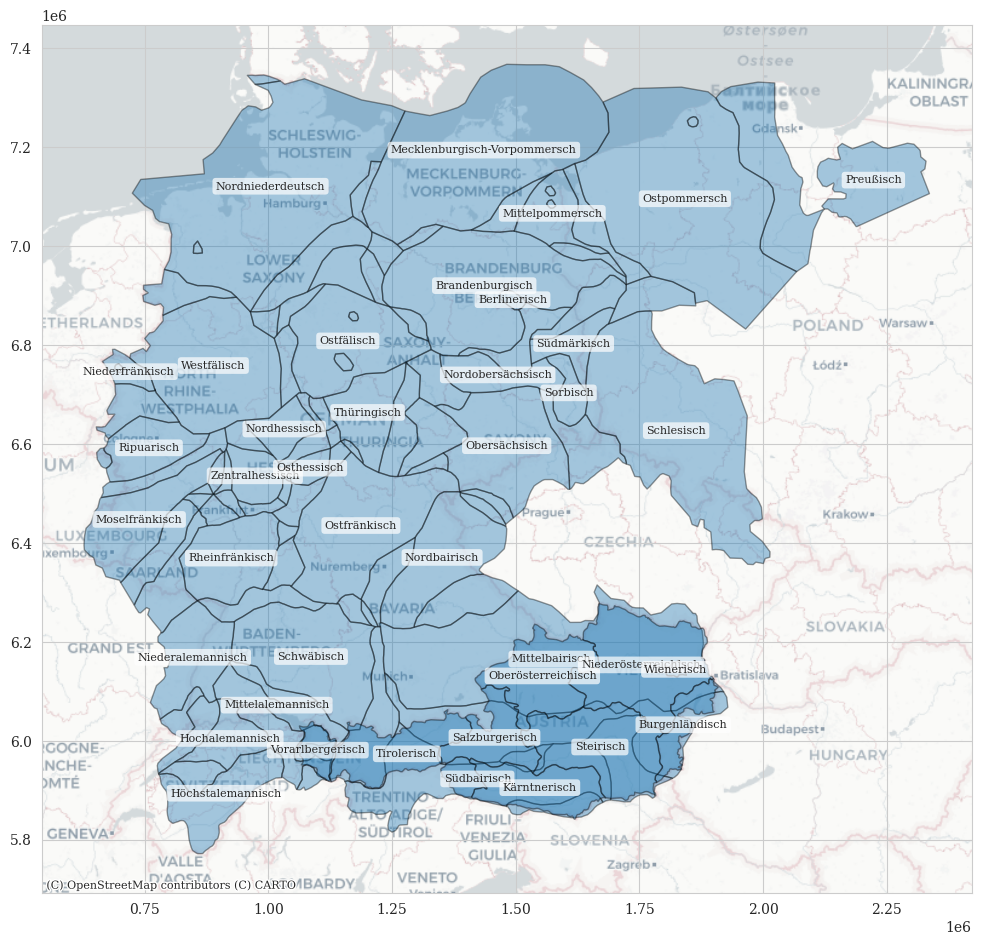

In [4]:
#visualise dialect polygons
gdf_mercator = gdf.to_crs(epsg=3857) #reproject to WebMercator for plotting with basemap

ax = gdf_mercator.plot(figsize=(12, 12), alpha=0.4, edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

#add labels
for idx, row in gdf_mercator.iterrows():
    # Get label text
    label = row['title']
    if "Übergangsgebiet" in label: #comment out these two lines to see transition zone labels
        continue
    #label polygon centroid
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.text(x, y, label, fontsize=8, ha='center', va='center', 
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3"))

plt.show()

In [5]:
def create_multipolygon(gdf, areas):
    """
    Creates a unified MultiPolygon from a list of area names by extracting and merging 
    corresponding geometries from a GeoDataFrame.

    Parameters:
    - gdf (GeoDataFrame): A GeoDataFrame containing geometries in a 'geometry' column and area names in a 'title' column.
    - areas (list of str): A list of area names to select and combine into one MultiPolygon.

    Returns:
    - shapely.geometry.MultiPolygon or Polygon or None: A unified geometry combining all 
        matching areas, or None if no valid geometries were found.
    """
    
    polygons=[]
    for area in areas: #go through rows in gdf
        row = gdf[gdf["title"] == area] 
        geometry = list(row.geometry)
        for geom in row.geometry: #append/extend geometry in each row
            if geom is None: #skip empty rows
                continue
            if isinstance(geom, Polygon):
                polygons.append(geom)
            elif isinstance(geom, MultiPolygon):
                polygons.extend(list(geom.geoms))
            else:
                print(f"Unexpected geometry type: {type(geom)}")
    if polygons: #unite polygons
        unioned = unary_union(polygons) 
        return unioned
    else:
        print(f"No geometry found for areas: {areas}")
        return None

# Create High Central Low polygons

In [6]:
#==low==
#low dialect polygons present in SprachGIS geojson file
low = ['Mecklenburgisch-Vorpommersch', 'Ostpommersch', 'Mittelpommersch','Niederfränkisch','Nordniederdeutsch','Ostfälisch', 'Brandenburgisch','Westfälisch','Preußisch', 'Berlinerisch'] 

#relevant transition zone (Übergangsgebiet) numbers
N = [9, 10, 11, 12, 13, 14, 15, 16, 17, 
     23, 24,
     41, 42, 43, 44, 45, 46, 47, 48, 49,
     70, 71, 72, 74, 75, 76, 77, #73 = berlin
     ]
for n in N:
    low.append(f"Übergangsgebiet {n}") 

#make polygon and gdf
low_poly = create_multipolygon(gdf_mercator, low)
low_gdf = gpd.GeoDataFrame(geometry=[low_poly], crs=gdf_mercator.crs)
low_gdf.to_file('./geojson/low_gdf_mercator.geojson', driver='GeoJSON')

In [7]:
#==central==
central = ['Osthessisch', 'Moselfränkisch', 'Südmärkisch', 'Obersächsisch', 'Nordobersächsisch','Schlesisch', 'Thüringisch', 'Zentralhessisch','Ripuarisch','Nordhessisch', 'Rheinfränkisch']
C = [1, 2, 3, 4, 5, 6, 7, 8, 
     18, 19,
     20, 21, 22, 25, 26, 27, 28, 29, 
     30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
     40, 50, 69
     ]
for c in C:
    central.append(f"Übergangsgebiet {c}")

central_poly = create_multipolygon(gdf_mercator, central)
central_gdf = gpd.GeoDataFrame(geometry=[central_poly], crs=gdf_mercator.crs)
central_gdf.to_file('./geojson/central_gdf_mercator.geojson', driver='GeoJSON')

In [8]:
#==high==
high = ['Mittelbairisch', 'Mittelalemannisch','Ostfränkisch','Hochalemannisch','Höchstalemannisch','Niederalemannisch', 'Nordbairisch', 'Schwäbisch','Südbairisch']
H = [51, 52, 53, 54, 55, 56, 57, 58, 59, 
     60, 61, 62, 63, 64, 65, 66, 67, 68
     ]
for h in H:
    high.append(f"Übergangsgebiet {h}")

high_poly = create_multipolygon(gdf_mercator, high)
high_gdf = gpd.GeoDataFrame(geometry=[high_poly], crs=gdf_mercator.crs)
high_gdf.to_file('./geojson/high_gdf_mercator.geojson', driver='GeoJSON')


In [9]:
#HCL
hcl = high + central + low
hcl_poly = create_multipolygon(gdf_mercator, hcl)
hcl_gdf = gpd.GeoDataFrame(geometry=[hcl_poly], crs=gdf_mercator.crs)
hcl_gdf.to_file('./geojson/hcl_gdf_mercator.geojson', driver='GeoJSON')

#==not low==
not_low = high + central
not_low_poly = create_multipolygon(gdf_mercator, not_low)
not_low_gdf = gpd.GeoDataFrame(geometry=[not_low_poly], crs=gdf_mercator.crs)
not_low_gdf.to_file('./geojson/not_low_gdf_mercator.geojson', driver='GeoJSON')

In [10]:
hole = ['Sorbisch'] #not a german dialect (Slavic)

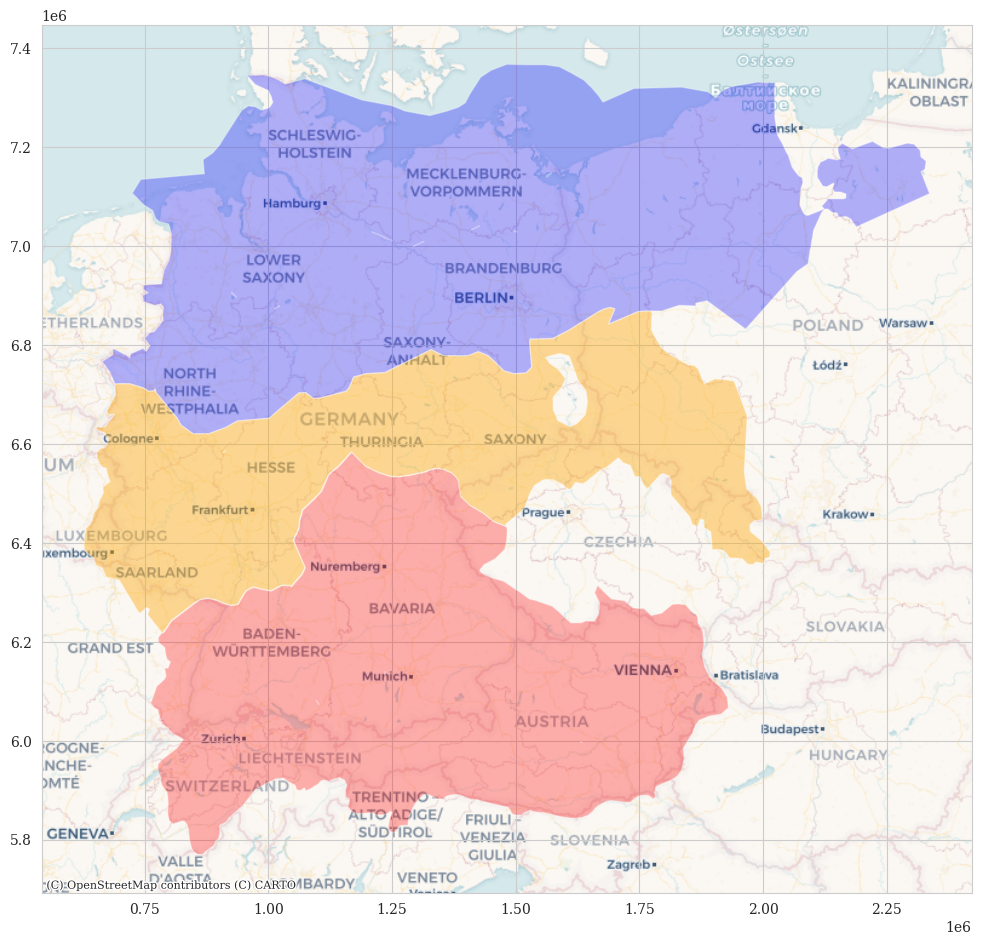

In [11]:
#plot high central low
fig, ax = plt.subplots(figsize=(12, 12))                
low_gdf.plot(ax=ax, alpha=0.3, color ='blue')
high_gdf.plot(ax=ax, alpha=0.3, color='red')
central_gdf.plot(ax=ax, alpha=0.4, color='orange')
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
plt.show()

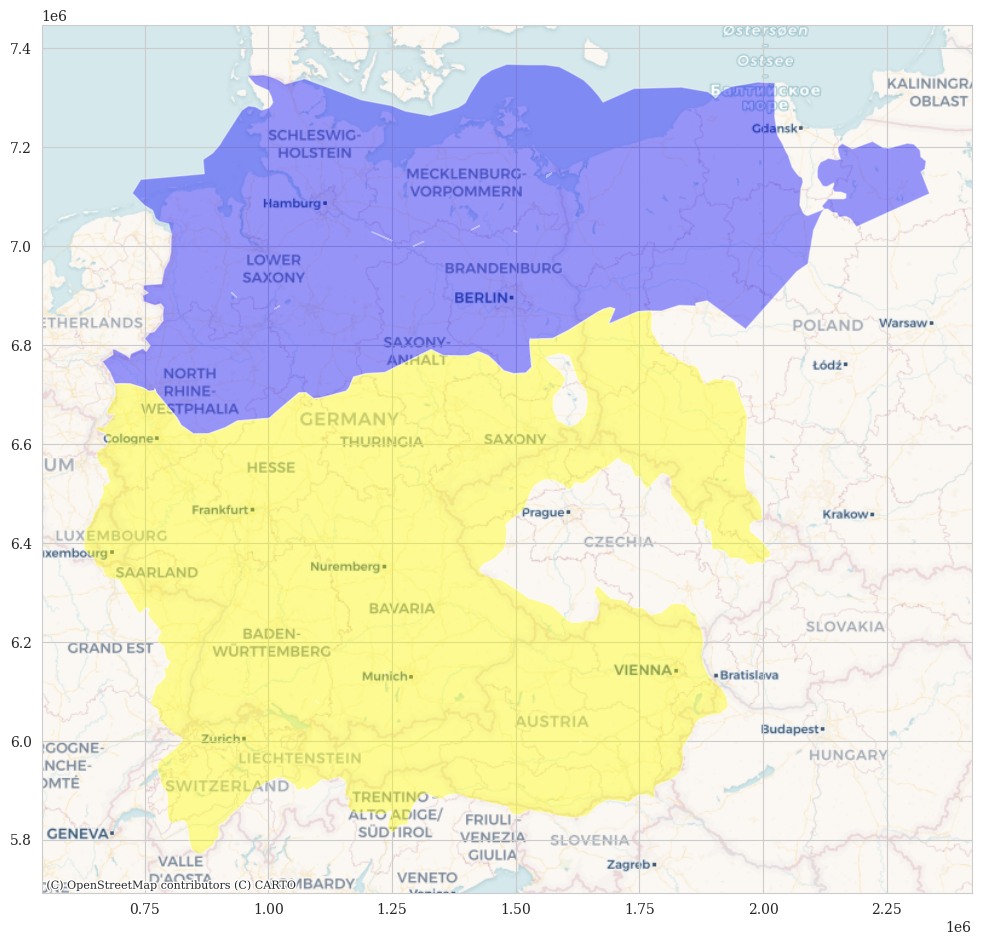

In [12]:
#plot low vs not low
fig, ax = plt.subplots(figsize=(12, 12))                
low_gdf.plot(ax=ax, alpha=0.4, color ='blue')
not_low_gdf.plot(ax=ax, alpha=0.4, color='yellow')
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
plt.show()

# Create aggregated dialect polygons

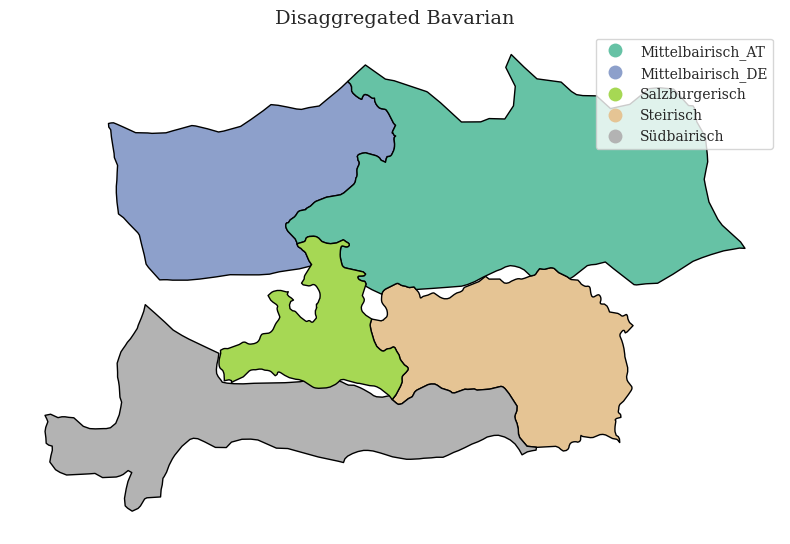

In [15]:
#split mittelbairisch into germany and austria
de_country = gpd.read_file("./geojson/original/de_country.geojson")
mittelbairisch_geom = gdf[gdf["title"] == "Mittelbairisch"].geometry.iloc[0] # Select Mittelbairisch geometry

# Clip to Austria (intersection) and get rest (difference)
mittelbairisch_de = mittelbairisch_geom.intersection(de_country.unary_union)
mittelbairisch_at = mittelbairisch_geom.difference(de_country.unary_union)

# Extract Steirisch and Südbairisch
steirisch_geom = gdf[gdf["title"] == "Steirisch"].geometry.iloc[0]
suedbairisch_geom = gdf[gdf["title"] == "Südbairisch"].geometry.iloc[0]
salzburg_geom = gdf[gdf["title"] == "Salzburgerisch"].geometry.iloc[0]

# Force non-overlapping: assign Steirisch the intersection, and subtract it from Südbairisch
steirisch_clean = steirisch_geom
suedbairisch_clean = suedbairisch_geom.difference(steirisch_geom)
mittelbairisch_at = mittelbairisch_at.difference(steirisch_geom)
mittelbairisch_at = mittelbairisch_at.difference(salzburg_geom)

# Create cleaned GeoDataFrame
ss_gdf = gpd.GeoDataFrame({
    "title": ["Mittelbairisch_DE", "Steirisch", "Südbairisch", "Mittelbairisch_AT", "Salzburgerisch"],
    "geometry": [mittelbairisch_de, steirisch_clean, suedbairisch_clean, mittelbairisch_at, salzburg_geom]
}, crs=gdf.crs)

#add to gdf
gdf = gdf[~gdf["title"].isin(["Mittelbairisch", "Steirisch", "Südbairisch", "Salzburgerisch"])]

gdf = pd.concat([gdf, ss_gdf], ignore_index=True)
gdf_mercator = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ss_gdf.plot(ax=ax, column='title', cmap='Set2', edgecolor='black', legend=True)
ax.set_title("Disaggregated Bavarian", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [16]:
gdf["title"].unique()

array(['Zentralhessisch', 'Westfälisch', 'Übergangsgebiet 9',
       'Übergangsgebiet 8', 'Übergangsgebiet 77', 'Übergangsgebiet 76',
       'Übergangsgebiet 75', 'Übergangsgebiet 74', 'Berlinerisch',
       'Übergangsgebiet 72', 'Übergangsgebiet 71', 'Übergangsgebiet 70',
       'Übergangsgebiet 7', 'Übergangsgebiet 69', 'Übergangsgebiet 68',
       'Übergangsgebiet 67', 'Übergangsgebiet 66', 'Übergangsgebiet 65',
       'Übergangsgebiet 64', 'Übergangsgebiet 63', 'Übergangsgebiet 62',
       'Übergangsgebiet 61', 'Übergangsgebiet 6', 'Übergangsgebiet 59',
       'Übergangsgebiet 58', 'Übergangsgebiet 57', 'Übergangsgebiet 56',
       'Übergangsgebiet 55', 'Übergangsgebiet 54', 'Übergangsgebiet 53',
       'Übergangsgebiet 52', 'Übergangsgebiet 51', 'Übergangsgebiet 50',
       'Übergangsgebiet 5', 'Übergangsgebiet 49', 'Übergangsgebiet 48',
       'Übergangsgebiet 47', 'Übergangsgebiet 46', 'Übergangsgebiet 45',
       'Übergangsgebiet 44', 'Übergangsgebiet 43', 'Preußisch',
       '

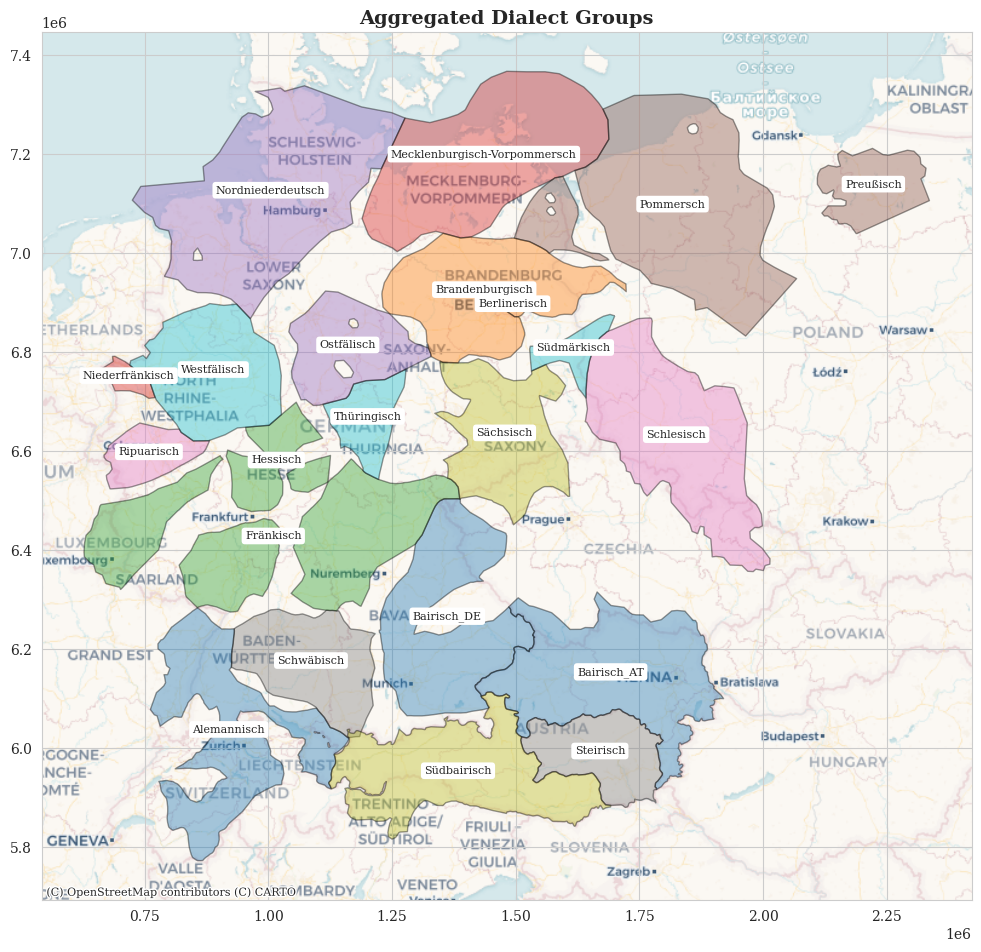

In [17]:
# aggregrate finer grained dialects into larger areas: don't have such granular answers in questionnaire responses, 
# and helps boost power by increasing sample size per cluster, as not enough respondents for each separate variant

sprachgis_dialects = {
  #region : dialect : subdialects
  "High": {
    "Alemannisch": ["Höchstalemannisch", "Hochalemannisch", "Mittelalemannisch", "Niederalemannisch", "Vorarlbergerisch"], #South West of DACH
    "Bairisch_DE": ["Nordbairisch", "Mittelbairisch_DE"], 
    "Bairisch_AT": ["Mittelbairisch_AT","Niederösterreichisch","Oberösterreichisch","Burgenländisch","Wienerisch"], #South East DE, Northern AT
    "Schwäbisch": ["Schwäbisch"],
    "Steirisch": ["Steirisch"],
    "Südbairisch": ["Tirolerisch","Kärntnerisch", "Südbairisch", "Salzburgerisch"], #Southern AT
  },
  "Central": {
    "Hessisch": ["Osthessisch", "Nordhessisch", "Zentralhessisch"],
    "Fränkisch": ["Ostfränkisch", "Rheinfränkisch", "Moselfränkisch"], #Niederfränkisch not included here as it is a LOW dialect
    "Sächsisch": ["Obersächsisch", "Nordobersächsisch"],
    "Thüringisch": ["Thüringisch"],
    "Ripuarisch": ["Ripuarisch"],
    "Schlesisch": ["Schlesisch"],
    "Südmärkisch": ["Südmärkisch"]
  },
  "Low": {
    "Nordniederdeutsch": ["Nordniederdeutsch"],
    "Mecklenburgisch-Vorpommersch": ["Mecklenburgisch-Vorpommersch"],
    "Berlinerisch": ["Berlinerisch"],
    "Pommersch": ["Ostpommersch", "Mittelpommersch"],
    "Niederfränkisch": ["Niederfränkisch"],
    "Ostfälisch": ["Ostfälisch"],
    "Brandenburgisch": ["Brandenburgisch"],
    "Westfälisch": ["Westfälisch"],
    "Preußisch":["Preußisch"]
  }
}

#unite geometries for each group
merged_shapes = []
for region, groups in sprachgis_dialects.items():
    for group, areas in groups.items():
        if areas:
            multipoly = create_multipolygon(gdf_mercator, areas)
            merged_shapes.append({
                "group": group,
                "region": region,
                "geometry": multipoly
            })

gdf_gjson = gpd.GeoDataFrame(merged_shapes, crs=gdf_mercator.crs)
gdf_gjson_mercator = gdf_gjson.to_crs(epsg=3857) #reproject to WebMercator for plotting
gdf_gjson_mercator.to_file('./geojson/agg_dialects_gdf_mercator.geojson', driver='GeoJSON')

#plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_gjson_mercator.plot(
    column="group",
    ax=ax,
    alpha=0.4,
    edgecolor="black",
    legend=False
)

for idx, row in gdf_gjson_mercator.iterrows():
    centroid = row["geometry"].centroid
    ax.text(
        centroid.x, centroid.y,
        row["group"],
        fontsize=8,
        ha="center",  bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3", clip_on=True)
    )
    
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_title("Aggregated Dialect Groups", fontsize=14, fontweight="bold")
plt.show()


# Exploring data

In [18]:
df_proc = pd.read_csv("./data/data_for_plotting.csv")

In [19]:
gpd.read_file('./HCL_data_for_plotting.geojson')

percent_s                                           geometry
0        30.95  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
1        36.59  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
2        21.95  MULTIPOLYGON (((810578.88165 6248049.98003, 80...
3        26.83  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
4        16.67  MULTIPOLYGON (((810578.88165 6248049.98003, 80...
..         ...                                                ...
171      33.33  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
172      28.57  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
173      26.19  MULTIPOLYGON (((954118.09268 5878830.44405, 94...
174      45.24  MULTIPOLYGON (((710369.96411 6780127.99780, 72...
175      35.71  MULTIPOLYGON (((710369.96411 6780127.99780, 72...

[176 rows x 2 columns]

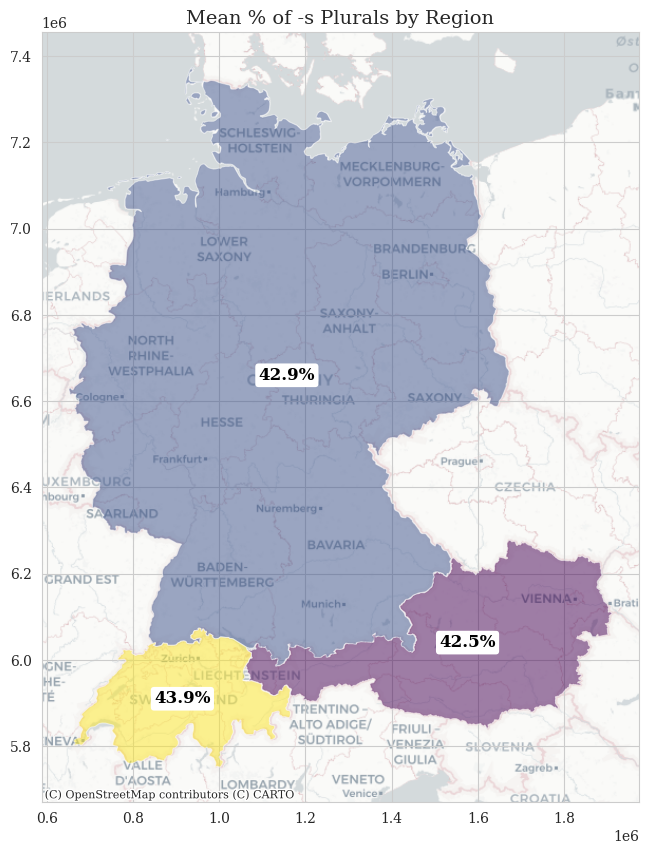

In [20]:
#=====DE vs AT=====
#load geojson files
at_country = gpd.read_file("./geojson/original/at_country.geojson")
de_country = gpd.read_file("./geojson/original/de_country.geojson")
ch_country = gpd.read_file("./geojson/original/ch_country.geojson")
countries = ["Germany", "Austria", "Switzerland"]

#get single geometry location
at_geom = at_country.to_crs(epsg=3857).unary_union
de_geom = de_country.to_crs(epsg=3857).unary_union
ch_geom = ch_country.to_crs(epsg=3857).unary_union

df = pd.read_csv("./data/data_for_plotting.csv")
df_deat = df.copy()

#calc mean over aggregated groups and then assign geometry (making sure crs matches that of polygons)
df_agg = df_deat.groupby("country", dropna=True)["percent_s"].mean().reset_index()
df_deat.loc[~df_deat["country"].isin(countries), "geometry"] = np.nan #anything w/o a country is NaN
df_agg["geometry"] = df_agg["country"].map({"Germany": de_geom, "Austria": at_geom, "Switzerland": ch_geom})
gdf_agg = gpd.GeoDataFrame(df_agg, geometry="geometry", crs="EPSG:3857")

#plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf_agg.plot(
    column="percent_s",
    cmap="viridis",
    legend=False,
    edgecolor="white",
    linewidth=0.8,
    alpha=0.5,
    ax=ax
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

#add labels
for idx, row in gdf_agg.iterrows():
    geom = row["geometry"]
    if geom is None or geom.is_empty:
        continue
    centroid = row["geometry"].centroid
    ax.text(
        centroid.x,
        centroid.y,
        f"{row['percent_s']:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        weight="bold",
        bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.2')
    )

ax.set_title("Mean % of -s Plurals by Region", fontsize=14)
plt.show()
